In [14]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
# assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "CNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action='ignore')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

class LeNet5(Model):

    def __init__(self, num_classes):
        """
        Initialize the model.
        :param num_classes:     Number of classes to predict from
        """
        super(LeNet5, self).__init__()
        # We instantiate the various layers composing LeNet-5:
        # self.conv1 = SimpleConvolutionLayer(6, kernel_size=(5, 5))
        # self.conv2 = SimpleConvolutionLayer(16, kernel_size=(5, 5))
        # ... or using the existing and (recommended) Conv2D class:

        # 합성곱 층을 생성 - 6은 커널(필터)의 개수, kernel_size는 연산을 수행할 단위
        # padding이 00 추가 여부 activation함수는 활성화 함수로 relu(RBF)
        self.conv1 = Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')
        self.conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')

        # 최대 풀링 층 - 2라고 설정해도 된다.
        self.max_pool = MaxPooling2D(pool_size=(2, 2))

        # 1차원으로 만들어주는 층
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')

        # 출력층
        self.dense3 = Dense(num_classes, activation='softmax')


    # 실제 층을 구성하는 함수
    def call(self, inputs):
        """
        Call the layers and perform their operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """

        # 합성곱을 첫번째 입력으로 해서 풀링 층 생성
        x = self.max_pool(self.conv1(inputs))        # 1st block

        # 다른 합성곱을 입력해서 풀링 층을 생성
        x = self.max_pool(self.conv2(x))             # 2nd block

        # 1차원으로 변형
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x

    #

In [ ]:
# 모델 생성 및 컴파일
# 경사하강법을 최적화 함수로 설정함.
model = LeNet5(num_classes)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
_ = model.predict(x_test[:10]) # fit을 하기전에 할 수 있음.

1/1 [==============================] - 7s 7s/step


In [ ]:
batched_input_shape = tf.TensorShape((None, *input_shape))
model.build(input_shape=batched_input_shape)
model.summary()

Model: "le_net5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  156       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  48120     
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                           

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)]

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=32, epochs=80, validation_data=(x_test, y_test),
                    verbose=2,  # change to `verbose=1` to get a progress bar
                                # (we opt for `verbose=2` here to reduce the log size)
                    callbacks=callbacks)

Epoch 1/80
1875/1875 - 10s - loss: 0.6153 - accuracy: 0.7984 - val_loss: 0.1490 - val_accuracy: 0.9529 - 10s/epoch - 6ms/step
Epoch 2/80
1875/1875 - 6s - loss: 0.1293 - accuracy: 0.9607 - val_loss: 0.0977 - val_accuracy: 0.9692 - 6s/epoch - 3ms/step
Epoch 3/80
1875/1875 - 7s - loss: 0.0915 - accuracy: 0.9722 - val_loss: 0.0652 - val_accuracy: 0.9782 - 7s/epoch - 3ms/step
Epoch 4/80
1875/1875 - 6s - loss: 0.0740 - accuracy: 0.9778 - val_loss: 0.0665 - val_accuracy: 0.9793 - 6s/epoch - 3ms/step
Epoch 5/80
1875/1875 - 7s - loss: 0.0643 - accuracy: 0.9803 - val_loss: 0.0579 - val_accuracy: 0.9805 - 7s/epoch - 4ms/step
Epoch 6/80
1875/1875 - 6s - loss: 0.0559 - accuracy: 0.9827 - val_loss: 0.0479 - val_accuracy: 0.9830 - 6s/epoch - 3ms/step
Epoch 7/80
1875/1875 - 7s - loss: 0.0496 - accuracy: 0.9847 - val_loss: 0.0558 - val_accuracy: 0.9815 - 7s/epoch - 3ms/step
Epoch 8/80
1875/1875 - 6s - loss: 0.0454 - accuracy: 0.9862 - val_loss: 0.0439 - val_accuracy: 0.9865 - 6s/epoch - 3ms/step
Epoch 

In [ ]:
_ = model.predict(x_test[:10])

1/1 [==============================] - 0s 38ms/step


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

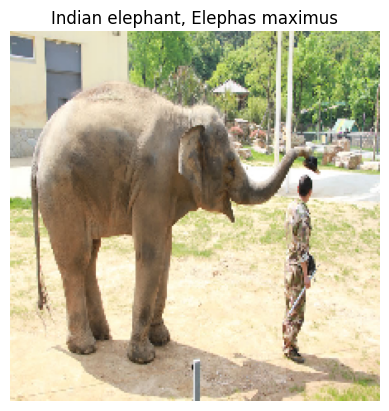

In [15]:
'''
ref1:
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5
ref2: # https://keras.io/applications/
'''
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.imagenet_utils  import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image # pip install pillow

model = VGG16(weights='imagenet', include_top=True) # weights= W
model.summary()

img_path = './data/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # (1, 224, 224, 3)
x = preprocess_input(x) # mode='caffe'
output = model.predict(x)

print('Predicted:', decode_predictions(output, top=5)[0])

k = np.argmax(output[0])            # top 1
z = output[0].argsort()[-5:][::-1]    # top 5

labels = {}
name = "./data/imagenet1000_clsidx_to_labels.txt"
with open(name, 'r') as f:
    C = [line[:-2] for line in f.readlines()]
C[0] = C[0][1:]
for line in C:
    line = line.replace("'", "")
    key, value = line.split(':')
    labels[int(key)] = value.strip()
print('Top-1 prediction:', labels[k])
print('Top-5 prediction:', [labels[i] for i in z])

plt.imshow(img)
plt.title(labels[k])
plt.axis("off")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import numpy as np
import matplotlib.pyplot as plt

# 기존 모델이 학습하지 않은 데이터를 추가해서 학습 - 클래스가 10개
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

x_train= preprocess_input(x_train)
x_test = preprocess_input(x_test)

# 기존 모델의 가중치만 이용해서 새로 학습하여 모델을 생성
# 층의 구조 등은 그대로 생성
# 분류할 종류가 10가지라서 클래스의 개수를 10으로 설정
# 학습할 이미지가 224가 아니라서 학습할 이미지 크기를 설정.
model = VGG16(weights=None, include_top=True, classes=10, input_shape=(32,32,3))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                validation_split=0.2, verbose=1, callbacks = callbacks)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
fig.tight_layout()
plt.show()